In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from astropy.io import fits
import copy
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from comet_ml import Experiment
from skimage.util import random_noise
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchmetrics import Dice, JaccardIndex
from torchsummary import summary

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/dario/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
hiperparametros = {'nombre_notebook': 'Training_NISP_H_1000imgs_v4.ipynb',
                    'nombre_experimento' : 'Training_NISP_H_1000imgs_v4',
                    'nombre_mejor_modelo_a_guardar' : 'NISP_H_1000imgs_v4',
                    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                    'ruta_galaxias' : 'galaxies_train_NISP_H/galaxy_and_stream_convolved*.fits',
                    'ruta_mascaras' : '../masks_train_NISP_H/mask_',
                    'ruta_galaxias_test' : 'galaxies_test_NISP_H/galaxy_and_stream_convolved*.fits',
                    'ruta_mascaras_test' : '../masks_train_NISP_H/mask_',
                    'ancho_imagen_original' : 200,
                    'alto_imagen_original' : 200,
                    'ancho_imagen_deseado' : 224,
                    'alto_imagen_deseado' : 224,
                    'epocas' : 100,
                    'lr' : 1e-3,
                    'regularizacion_ridge' : 1e-5,
                    'torch seed model weights' : 10,
                    'batch_size' : 4,
                    'loss' : torch.nn.CrossEntropyLoss()}
device = hiperparametros['device']

In [4]:
experiment = Experiment(
    api_key="dhgO2PK521nSSpRLBYPemvvs7",
    project_name="general",
    workspace="dario-torre",
    
)
experiment.set_name(hiperparametros['nombre_experimento'])
experiment.log_parameters(hiperparametros)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/dario-torre/general/0cc15186e0b747f5b4d3d5ffbf79df25



In [22]:
def get_galaxy_number(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[4]

def get_galaxy_magnitude(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[5]

def normalize_01(inp: np.ndarray):
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def imagen_logaritmica(img: np.ndarray)->np.ndarray:
    """
    Escalamos de forma logarítmica la imagen para aumentar el contraste
    """
    
    img_log = np.log(img, where=(img>0))
    valor_minimo = np.min(img_log)
    print("valor minimo en log: "+str(valor_minimo) )
    np.putmask(img_log, img!=0, img_log+abs(valor_minimo))
    return img_log


In [23]:
def print_histogram(x):
    x = copy.deepcopy(x)
    print(x)
    valor_minimo = np.min(x)
    print("valor_minimo:"+str(valor_minimo))
    print("tipo:"+str(x.dtype))
    # Mostrar el histograma de los valores de los píxeles
    plt.figure(figsize=(10, 6))
    plt.hist(x.flatten(), bins=100, color='blue', alpha=0.7)
    plt.title('Histograma de Valores de los Píxeles')
    plt.xlabel('Valor del Píxel')
    plt.ylabel('Frecuencia')
    plt.yscale('log')  # Usar escala logarítmica para mejor visualización
    plt.grid(True)
    plt.show()

In [52]:
class MyDataset(Dataset):
    """
    Dataset básico sin ningún tipo de augmentation
    """
    def __init__(self, galaxias_con_colas_de_marea, transform=None):
        """
        Constructor del dataset
        @param galaxias_con_colas_de_marea: Lista de rutas a los ficheros que contienen los datos de las galaxias
        """
        self.galaxias_con_colas_de_marea = galaxias_con_colas_de_marea
        self.transform=transform

    def __getitem__(self, index):
        #Abrimos la imagen de la galaxia con cola de marea
        galaxy_fits = fits.open(self.galaxias_con_colas_de_marea[index])

        x = galaxy_fits[0].data.astype(np.float32)
        
        #Abrimos la mascara correspondiente a la imagen
        numero_galaxia = get_galaxy_number(self.galaxias_con_colas_de_marea[index])
        magnitud_galaxia = get_galaxy_magnitude(self.galaxias_con_colas_de_marea[index])
        y = np.array(cv2.imread(hiperparametros['ruta_mascaras']+str(numero_galaxia)+"_"+str(magnitud_galaxia)+".png",0)).astype(np.float32)
        
        if self.transform is not None:
            mean = 1.0881466
            std = mean*0.1
            gaussian_noise = np.random.normal(mean, std, x.shape).astype(np.float32)
            #print("Ruido gaussiano:")
            #print_histogram(gaussian_noise)
            x = x + gaussian_noise
            x = np.clip(x, 0, None)
            #print("despues de clippear:")
            #print_histogram(x)
        x = imagen_logaritmica(x)
        #("despues de logaritmo:")
        #print_histogram(x)
        x = normalize_01(x)
        #print("despues de normalizar:")
        #print_histogram(x)
        
        # Assuming 'input_item' is your input image
        x = cv2.resize(x, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        y = cv2.resize(y, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        if(self.transform is not None):
            augmented = self.transform(image=x, mask=y)
            x_tensor= augmented["image"]
            y_tensor= augmented["mask"].long()
        else:
            x_tensor = torch.from_numpy(x).float()
            x_tensor=torch.unsqueeze(x_tensor, dim=0)
            y_tensor = torch.from_numpy(y).long()
        
        #Hacemos reshape de los tensores
        y_tensor=torch.unsqueeze(y_tensor, dim=0)
        return x_tensor, y_tensor
    
    def __len__(self):
        """
        Devuelve la longitud del dataset
        """
        return len(self.galaxias_con_colas_de_marea)
    
class MyDatasetTest(Dataset):
    """
    Dataset básico sin ningún tipo de augmentation
    """
    def __init__(self, galaxias_con_colas_de_marea, transform=None):
        """
        Constructor del dataset
        @param galaxias_con_colas_de_marea: Lista de rutas a los ficheros que contienen los datos de las galaxias
        """
        self.galaxias_con_colas_de_marea = galaxias_con_colas_de_marea
        self.transform=transform

    def __getitem__(self, index):
        #Abrimos la imagen de la galaxia con cola de marea
        galaxy_fits = fits.open(self.galaxias_con_colas_de_marea[index])
        x = galaxy_fits[0].data.astype(np.float32)
        #Abrimos la mascara correspondiente a la imagen
        numero_galaxia = get_galaxy_number(self.galaxias_con_colas_de_marea[index])
        magnitud_galaxia = get_galaxy_magnitude(self.galaxias_con_colas_de_marea[index])
        y = np.array(cv2.imread(hiperparametros['ruta_mascaras_test']+str(numero_galaxia)+"_"+str(magnitud_galaxia)+".png",0)).astype(np.float32)
        x = imagen_logaritmica(x)
        x = normalize_01(x)
        # Assuming 'input_item' is your input image
        x = cv2.resize(x, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        y = cv2.resize(y, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        if(self.transform is not None):
            augmented = self.transform(image=x, mask=y)
            x_tensor= augmented["image"]
            y_tensor= augmented["mask"].long()
        else:
            x_tensor = torch.from_numpy(x).float()
            x_tensor=torch.unsqueeze(x_tensor, dim=0)
            y_tensor = torch.from_numpy(y).long()
        
        #Hacemos reshape de los tensores
        y_tensor=torch.unsqueeze(y_tensor, dim=0)
        return x_tensor, y_tensor
    
    def __len__(self):
        """
        Devuelve la longitud del dataset
        """
        return len(self.galaxias_con_colas_de_marea)

In [53]:
augmentation = A.Compose([
    A.Flip(p=0.8),
    #A.Rotate(limit=(-180, 180), border_mode='random', p=0.99), 
    A.ShiftScaleRotate(shift_limit=0.4, rotate_limit=180, p=0.8),
    #A.GaussNoise(var_limit=(1.0881466*0.0001), mean=(0.0), p=0.99),
    ToTensorV2(),
])

In [54]:
imagenes_train = glob.glob(hiperparametros['ruta_galaxias'])
imagenes_valid = glob.glob(hiperparametros['ruta_galaxias_test'])
print("Number of train images: " + str(len(imagenes_train)))
print("Number of valid images: " + str(len(imagenes_valid)))
dataset_augmentations = MyDataset(imagenes_train, augmentation)
train_dataset= ConcatDataset([dataset_augmentations])
valid_dataset= MyDatasetTest(imagenes_valid)
train_dataloader = DataLoader(train_dataset, batch_size=hiperparametros['batch_size'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=hiperparametros['batch_size'], shuffle=True)

Number of train images: 6996
Number of valid images: 1749


## Creación del modelo

In [55]:
unet = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [56]:
torch.manual_seed(hiperparametros['torch seed model weights'])
unet.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [57]:
#Imprimimos la arquitectura de la red
summary(unet, (1, 608, 608))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 304, 304]           3,136
       BatchNorm2d-2         [-1, 64, 304, 304]             128
              ReLU-3         [-1, 64, 304, 304]               0
         MaxPool2d-4         [-1, 64, 152, 152]               0
            Conv2d-5         [-1, 64, 152, 152]          36,864
       BatchNorm2d-6         [-1, 64, 152, 152]             128
              ReLU-7         [-1, 64, 152, 152]               0
            Conv2d-8         [-1, 64, 152, 152]          36,864
       BatchNorm2d-9         [-1, 64, 152, 152]             128
             ReLU-10         [-1, 64, 152, 152]               0
       BasicBlock-11         [-1, 64, 152, 152]               0
           Conv2d-12         [-1, 64, 152, 152]          36,864
      BatchNorm2d-13         [-1, 64, 152, 152]             128
             ReLU-14         [-1, 64, 1

valor minimo en log: -12350704.0
despues de logaritmo:
[[ 12350704.  12350705. -12350704. ...  12350704.  12350704.  12350701.]
 [ 12350704.  12350704.  12350704. ...  12350705.  12350703.  12350701.]
 [ 12350705.  12350703.  12350705. ...  12350704.  12350704.  12350704.]
 ...
 [        0.  12350704.  12350705. ...  12350704.  12350705.  12350704.]
 [ 12350705.         0.  12350703. ...  12350704.  12350705.  12350703.]
 [        0.  12350705.  12350705. ...  12350704.  12350705.  12350704.]]
valor_minimo:-12350704.0
tipo:float32


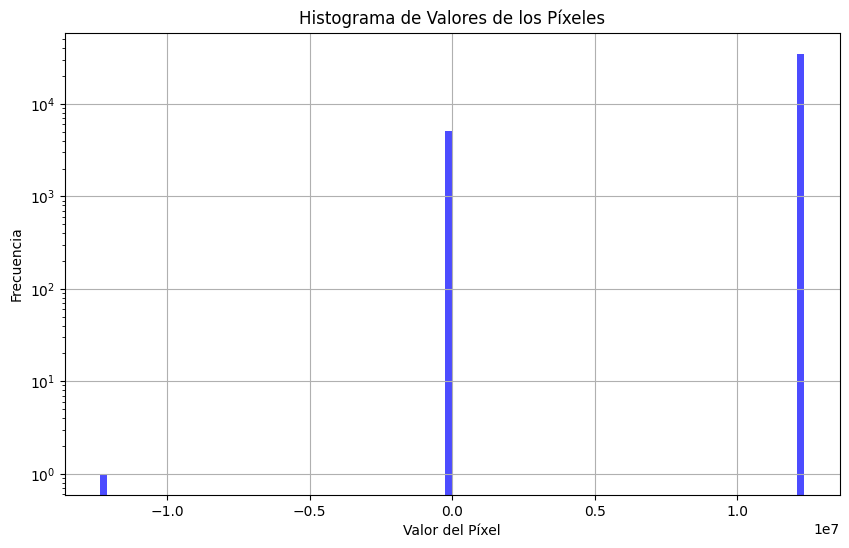

torch.Size([2, 224, 224])


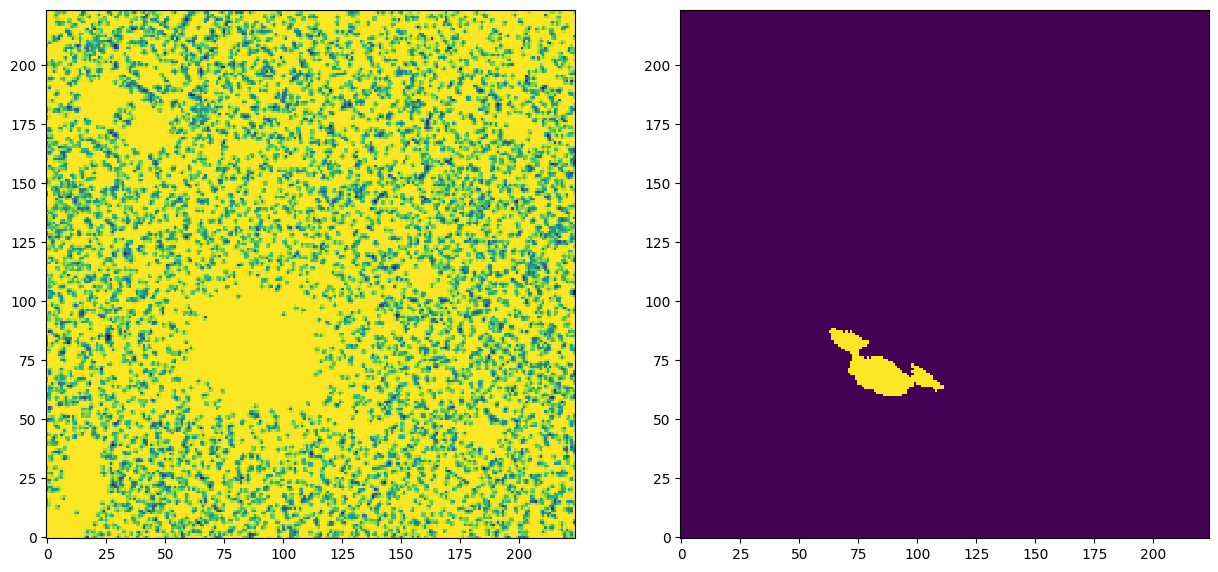

In [58]:
#Comprobamos que hemos construido la arquitectura de la red correctamente cargando una imagen del dataset
input_item, label_item = train_dataset.__getitem__(0)
input_item = input_item.reshape((1,1,hiperparametros['ancho_imagen_deseado'],hiperparametros['alto_imagen_deseado']))
label_item = label_item.reshape((1,1,hiperparametros['ancho_imagen_deseado'],hiperparametros['alto_imagen_deseado']))
output_item = unet(input_item.to(device)).cpu().detach().squeeze()
print(output_item.shape)
out_softmax = torch.softmax(output_item, dim=0)
mascara_predicha = torch.argmax(out_softmax, dim=0).numpy()
fig, (axs0, axs1) = plt.subplots(1,2, figsize = (15,15))
axs0.imshow(input_item.squeeze(), interpolation='none', origin="lower")
axs1.imshow(label_item.squeeze(), interpolation='none', origin="lower")
#plt.imshow(mascara_predicha, interpolation='none', origin="lower")
#plt.colorbar()
plt.show()


## Bucle de entrenamiento

In [ ]:
criterio_loss = hiperparametros['loss']
optimizer = torch.optim.Adam(unet.parameters(), lr=hiperparametros['lr'], weight_decay = hiperparametros['regularizacion_ridge'])
mejor_modelo = None
mejor_loss = 100000000

#Inicializamos la métrica de Dice
dice = Dice(num_classes=2, average='macro', ignore_index=0)
dice.cuda()
# Inicializamos la métrica de IoU
iou = JaccardIndex(task='multiclass', num_classes=2, average='macro', ignore_index=0)
iou.cuda()

train_loss_list = []
valid_loss_list = []
train_dice_list = []
valid_dice_list = []
train_iou_list = []
valid_iou_list = []

for epoch in range(hiperparametros['epocas']):
    experiment.set_epoch(epoch)
    #Parte de train
    loss_medio_train = 0
    dice_medio_train=0
    iou_medio_train = 0
    pasos_train = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = unet(inputs)
        targets = torch.squeeze(labels, dim=1).type(torch.LongTensor).to(device)
        loss = criterio_loss(outputs, targets)
        valor_dice = dice(outputs, targets)
        valor_iou = iou(outputs, targets)
        loss_medio_train += loss.item()
        dice_medio_train += valor_dice.item()
        iou_medio_train += valor_iou.item()
        pasos_train += 1
        loss.backward()
        optimizer.step()
    
    experiment.log_metric('Loss train', loss_medio_train/pasos_train)
    experiment.log_metric('Dice train', dice_medio_train/pasos_train)
    experiment.log_metric('IoU train', iou_medio_train/pasos_train)
    unet.eval()
    
    #Parte de validacion
    loss_medio_valid = 0
    dice_medio_valid = 0
    iou_medio_valid = 0
    pasos_valid = 0
    
    for i, data in enumerate(valid_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = unet(inputs)
        targets = torch.squeeze(labels, dim=1).type(torch.LongTensor).to(device)        
        loss = criterio_loss(outputs, targets)
        valor_dice = dice(outputs, targets)
        valor_iou = iou(outputs, targets)
        loss_medio_valid += loss.item()
        dice_medio_valid += valor_dice.item()
        iou_medio_valid += valor_iou.item()
        pasos_valid += 1
    experiment.log_metric('Loss valid', loss_medio_valid/pasos_valid)
    experiment.log_metric('Dice valid', dice_medio_valid/pasos_valid)
    experiment.log_metric('IoU valid', iou_medio_valid/pasos_valid)
    #Resultados del epoch
    print("Época: "+ str(epoch) +": Loss_train:"+ str(loss_medio_train/pasos_train)+" Loss_valid:"+str(loss_medio_valid/pasos_valid)+ "\n Dice_train: "+ str(dice_medio_train/pasos_train)+ " Dice_valid: "+str(dice_medio_valid/pasos_valid)+ " IoU_train: "+ str(iou_medio_train/pasos_train)+ " IoU_valid: "+str(iou_medio_valid/pasos_valid))
    train_loss_list.append(loss_medio_train/pasos_train)
    valid_loss_list.append(loss_medio_valid/pasos_valid)
    train_dice_list.append(dice_medio_train/pasos_train)
    valid_dice_list.append(dice_medio_valid/pasos_valid)
    train_iou_list.append(iou_medio_train/pasos_train)
    valid_iou_list.append(iou_medio_valid/pasos_valid)
    if (loss_medio_valid/pasos_valid) < mejor_loss:
        mejor_modelo = copy.deepcopy(unet)
        mejor_loss = loss_medio_valid/pasos_valid
    unet.train()
print('\n\nFinished Training')
print('Mejor loss sobre validación alcanzado:', mejor_loss)

In [ ]:
torch.save(mejor_modelo.state_dict(), hiperparametros['nombre_mejor_modelo_a_guardar'])

## Comprobar resultados con el conjunto de train

In [ ]:
"""
ancho = hiperparametros['ancho_imagen_deseado']
alto =hiperparametros['alto_imagen_deseado']
np.set_printoptions(threshold=sys.maxsize)
mejor_modelo.eval()
for i in range(int(len(train_dataset)*0.01)):
    item_dataset = train_dataset.__getitem__(i)
    item_x = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    item_label = item_dataset[1].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    #Obtenemos predicción de la red
    prediccion_item_tensor = mejor_modelo(item_dataset[0].reshape((1,1,ancho,alto)).to(device)).cpu().detach().squeeze()
    out_softmax = torch.softmax(prediccion_item_tensor, dim=0) #Aplicamos una softmax al final (teoricamente no afecta)
    mascara_predicha = torch.argmax(out_softmax, dim=0).numpy()
    #Mostramos imagen, mascara y mascara predicha
    fig, (axs0, axs1, axs2) = plt.subplots(1,3, figsize = (15,15))    
    axs0.imshow(item_x, interpolation='none', origin="lower")
    axs1.imshow(item_label, interpolation='none', origin="lower")
    axs2.imshow(mascara_predicha, interpolation='none', origin="lower")
    plt.show()
"""

## Comprobar resultados con el conjunto de validacion

In [ ]:
"""
ancho = hiperparametros['ancho_imagen_deseado']
alto =hiperparametros['alto_imagen_deseado']
np.set_printoptions(threshold=sys.maxsize)
mejor_modelo.eval()
for i in range(int(len(valid_dataset)*0.2)):
    item_dataset = valid_dataset.__getitem__(i)
    item_x = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    item_label = item_dataset[1].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    #Obtenemos predicción de la red
    prediccion_item_tensor = mejor_modelo(item_dataset[0].reshape((1,1,ancho,alto)).to(device)).cpu().detach().squeeze()
    mascara_predicha = torch.argmax(prediccion_item_tensor, dim=0).numpy()
    #Mostramos imagen, mascara y mascara predicha
    fig, (axs0, axs1, axs2) = plt.subplots(1,3, figsize = (15,15))
    axs0.imshow(item_x, interpolation='none', origin="lower")
    axs1.imshow(item_label, interpolation='none', origin="lower")
    axs2.imshow(mascara_predicha, interpolation='none', origin="lower")
    plt.show()
"""

In [ ]:
experiment.end()